In [ ]:
# 시계열 예측
# 자연어 처리?
# 자연어 -> 텐서로 변환
# 0차원 텐서는 스칼라

In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# toy dataset
# sklearn make_moons make_blobs
def make_ts(batch_size, n_steps): # batch_size개의 시계열들을 만들고, 각 시계열의 길이는 n_steps
  # sine 함수 2개랑 noise 섞어서 만들기
  freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time-offset1) * (freq1 * 10 + 10))
  series += 0.2 * np.sin((time-offset2) * (freq2 * 20 + 20))
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
  return series[..., np.newaxis].astype(np.float32) # newaxis 전: (a, b, c); 후: (a, b, c, 1)

In [3]:
seed = 42
np.random.seed(seed)

In [7]:
n_steps = 50
series = make_ts(10000, n_steps + 10)
# 시계열 50스텝을 보고 다음 10스텝 보려고
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10))
# 50 스텝 보는데, 각 스텝 볼 때마다 그 직후 10개를 정답으로
# 0번째 스텝 --> 1~10까지 Y로 두기
# 1번째 스텝 --> 2~11까지 Y로 두기
# ...
for step_ahead in range(1, 11):
  Y[..., step_ahead-1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train, Y_valid, Y_test = Y[:7000], Y[7000:9000], Y[9000:]

In [ ]:
# 그림 그리는 함수 따로 올려놓기
# RNN이랑 직접 관련 X

In [8]:
# 사용자 정의 성능 지표
# 50개 보고 그 다음 10개 맞히는 시계열 예측 문제
# 마지막 스텝에서만 MSE 계산
def last_mse(Y_true, Y_hat):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_hat[:, -1]) # batch 전체에 대해 (:)

In [13]:
model = keras.models.Sequential([
    # keras.layers.SimpleRNN()
    # keras.layers.LSTM()

    # 입력 층은 폭은 자유
    keras.layers.GRU(64, return_sequences=True, input_shape=[None, 1]), # None: batch_size가 들어올 자리, 1: 스칼라

    # 각자 튜닝
    #keras.layers.LSTM(40, return_sequences=True),

    #keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),


    keras.layers.TimeDistributed(keras.layers.Dense(10)),
])

In [14]:
lr = 6e-4
num_epochs = 40
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=[last_mse])
history = model.fit(X_train, Y_train, epochs=num_epochs, validation_data=(X_valid, Y_valid))

Epoch 1/40
219/219 [==============================] - 5s 8ms/step - loss: 0.0822 - last_mse: 0.0742 - val_loss: 0.0570 - val_last_mse: 0.0487
Epoch 2/40
219/219 [==============================] - 1s 6ms/step - loss: 0.0580 - last_mse: 0.0490 - val_loss: 0.0514 - val_last_mse: 0.0430
Epoch 3/40
219/219 [==============================] - 1s 6ms/step - loss: 0.0528 - last_mse: 0.0437 - val_loss: 0.0482 - val_last_mse: 0.0393
Epoch 4/40
219/219 [==============================] - 2s 7ms/step - loss: 0.0503 - last_mse: 0.0399 - val_loss: 0.0460 - val_last_mse: 0.0360
Epoch 5/40
219/219 [==============================] - 2s 7ms/step - loss: 0.0477 - last_mse: 0.0366 - val_loss: 0.0439 - val_last_mse: 0.0332
Epoch 6/40
219/219 [==============================] - 2s 7ms/step - loss: 0.0456 - last_mse: 0.0339 - val_loss: 0.0403 - val_last_mse: 0.0283
Epoch 7/40
219/219 [==============================] - 2s 9ms/step - loss: 0.0415 - last_mse: 0.0277 - val_loss: 0.0369 - val_last_mse: 0.0212
Epoch 

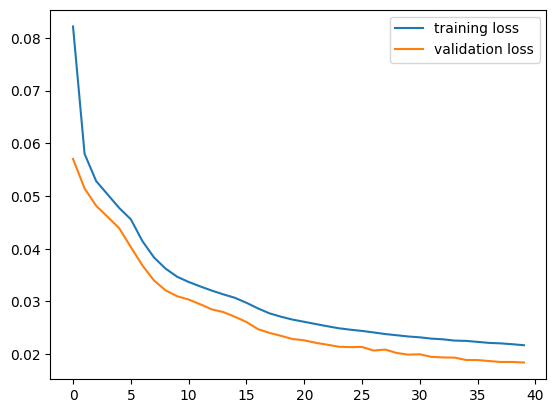

In [15]:
_, ax = plt.subplots()
ax.plot(history.history["loss"], label="training loss")
ax.plot(history.history["val_loss"], label="validation loss")
ax.legend()
plt.show()

In [16]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 4ms/step - loss: 0.0186 - last_mse: 0.0042


[0.018639106303453445, 0.004157617688179016]

In [17]:
# 시계열 그림 그리기
# x축이 t (시간)
# y축이 x(t) 시간의 함수로 반환되는 값
# 정답 파란 원으로 그림 (Target)
# 예측 값은 빨강 x로 그림 (Prediction)
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")


In [18]:
# training loss, validation loss 플롯
# 위의 history 참고해서 그려도 됨
import matplotlib as mpl
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0, 0.1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)



In [19]:
# 예측 시계열, 정답 시계열 같은 플롯에 겹쳐 그리기
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


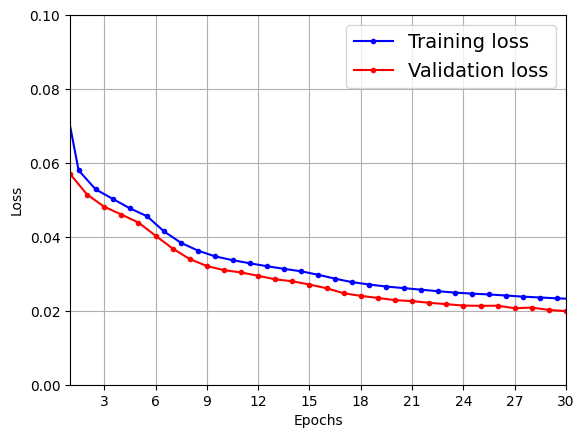

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

313/313 [==============================] - 1s 2ms/step


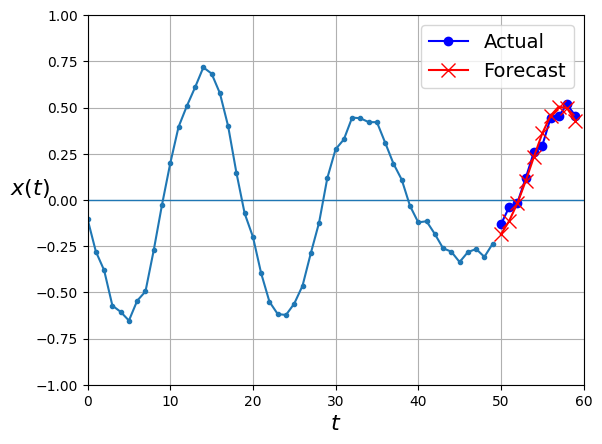

In [22]:
np.random.seed(40)
ts = make_ts(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_hat = model.predict(X_new)[:, -1][...,np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_hat)
plt.show()